In [1]:
# Import all required libraries at the top of the notebook
import requests         # For API calls to OpenWeatherMap
import time             # For time-based operations
from datetime import datetime  # To convert timestamps
import matplotlib.pyplot as plt  # For visualizations (later)


In [2]:
import sqlite3

In [3]:
# Replace with your actual OpenWeatherMap API key
API_KEY = '2ad4b87029e89b26b3fa26d785e13de1'


In [4]:
# Function to fetch weather data for a specific city
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()
    
    # Extract relevant weather data
    weather_data = {
        'city': city,
        'main': data['weather'][0]['main'],  # Main weather condition
        'temp_k': data['main']['temp'],  # Temperature in Kelvin
        'feels_like_k': data['main']['feels_like'],  # Feels like temperature in Kelvin
        'dt': datetime.utcfromtimestamp(data['dt']).strftime('%Y-%m-%d %H:%M:%S')  # Convert timestamp to readable format
    }
    
    return weather_data


In [5]:
# Test the function by fetching weather data for Delhi
city = 'Delhi'
weather_data = get_weather_data(city)
print(weather_data)


{'city': 'Delhi', 'main': 'Haze', 'temp_k': 305.2, 'feels_like_k': 306.07, 'dt': '2024-10-20 12:29:52'}


C:\Users\user\AppData\Local\Temp\ipykernel_11440\2998573195.py:13: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  'dt': datetime.utcfromtimestamp(data['dt']).strftime('%Y-%m-%d %H:%M:%S')  # Convert timestamp to readable format


In [6]:
from datetime import timezone  # Add this to handle timezones

# Function to fetch weather data for a specific city
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()
    
    # Extract relevant weather data
    weather_data = {
        'city': city,
        'main': data['weather'][0]['main'],  # Main weather condition
        'temp_k': data['main']['temp'],  # Temperature in Kelvin
        'feels_like_k': data['main']['feels_like'],  # Feels like temperature in Kelvin
        # Use timezone-aware objects to represent datetimes in UTC
        'dt': datetime.fromtimestamp(data['dt'], tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    }
    
    return weather_data


In [7]:
# Function to convert temperature from Kelvin to Celsius
def kelvin_to_celsius(temp_k):
    return temp_k - 273.15


In [8]:
# Convert the temperature to Celsius and display the result
temp_k = weather_data['temp_k']
temp_c = kelvin_to_celsius(temp_k)
print(f"Temperature in {city}: {temp_c:.2f}°C")


Temperature in Delhi: 32.05°C


In [9]:
# List of cities
CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']

# Fetch and display weather data for each city
for city in CITIES:
    weather_data = get_weather_data(city)
    temp_c = kelvin_to_celsius(weather_data['temp_k'])
    print(f"{city}: {temp_c:.2f}°C, {weather_data['main']}")


Delhi: 31.05°C, Haze
Mumbai: 29.99°C, Haze
Chennai: 29.51°C, Mist
Bangalore: 23.84°C, Clouds
Kolkata: 28.97°C, Haze
Hyderabad: 28.23°C, Haze


In [10]:
import sqlite3


In [11]:
# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('weather_data.db')
cursor = conn.cursor()

# Create a table to store weather data if it doesn't already exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS weather (
    city TEXT,
    dt TEXT,
    temp_c REAL,
    main TEXT
)
''')
conn.commit()  # Save changes


In [12]:
# Function to store weather data in the SQLite database
def store_weather_data(city, dt, temp_c, main):
    cursor.execute('''
    INSERT INTO weather (city, dt, temp_c, main)
    VALUES (?, ?, ?, ?)
    ''', (city, dt, temp_c, main))
    conn.commit()  # Save changes


In [13]:
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()
    
    # Extract relevant weather data
    weather_data = {
        'city': city,
        'main': data['weather'][0]['main'],  # Main weather condition
        'temp_k': data['main']['temp'],  # Temperature in Kelvin
        'feels_like_k': data['main']['feels_like'],  # Feels like temperature in Kelvin
        'dt': datetime.fromtimestamp(data['dt'], tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')  # Convert timestamp to readable format
    }
    
    # Convert temperature from Kelvin to Celsius
    temp_c = kelvin_to_celsius(weather_data['temp_k'])
    
    # Store the data in the SQLite database
    store_weather_data(city, weather_data['dt'], temp_c, weather_data['main'])
    
    return weather_data


In [14]:
# Fetch weather data for multiple cities and store in the database
for city in CITIES:
    get_weather_data(city)


In [15]:
# Query the weather data from the database
cursor.execute('SELECT * FROM weather')
rows = cursor.fetchall()

for row in rows:
    print(row)


('Delhi', '2024-10-20 12:39:18', 31.05000000000001, 'Haze')
('Mumbai', '2024-10-20 12:35:28', 29.99000000000001, 'Haze')
('Chennai', '2024-10-20 12:41:48', 29.510000000000048, 'Mist')
('Bangalore', '2024-10-20 12:40:06', 23.840000000000032, 'Clouds')
('Kolkata', '2024-10-20 12:37:37', 28.970000000000027, 'Haze')
('Hyderabad', '2024-10-20 12:41:49', 28.230000000000018, 'Haze')


In [16]:
# Function to calculate daily weather summary for a specific city
def calculate_daily_summary(city):
    # Query temperature data for the city from the database
    cursor.execute('''
    SELECT temp_c, main
    FROM weather
    WHERE city = ? AND dt >= DATE('now', '-1 day')
    ''', (city,))
    rows = cursor.fetchall()

    if not rows:
        print(f"No data available for {city} in the last 24 hours.")
        return

    temps = [row[0] for row in rows]
    weather_conditions = [row[1] for row in rows]
    
    # Calculate summary statistics
    avg_temp = sum(temps) / len(temps)
    max_temp = max(temps)
    min_temp = min(temps)
    
    # Find the dominant weather condition
    dominant_weather = max(set(weather_conditions), key=weather_conditions.count)

    # Print the summary
    print(f"Weather Summary for {city} (Last 24 Hours):")
    print(f"Average Temperature: {avg_temp:.2f}°C")
    print(f"Maximum Temperature: {max_temp:.2f}°C")
    print(f"Minimum Temperature: {min_temp:.2f}°C")
    print(f"Dominant Weather Condition: {dominant_weather}")


In [17]:
# Calculate daily summary for Delhi
calculate_daily_summary('Delhi')


Weather Summary for Delhi (Last 24 Hours):
Average Temperature: 31.05°C
Maximum Temperature: 31.05°C
Minimum Temperature: 31.05°C
Dominant Weather Condition: Haze


In [18]:
# Define temperature thresholds (in Celsius)
THRESHOLD = {
    'high_temp': 35,  # Alert if temperature exceeds 35°C
    'consecutive_updates': 2  # Number of consecutive updates to trigger the alert
}


In [19]:
# Initialize a dictionary to track consecutive alerts
alert_counter = {}

# Function to check weather data against thresholds and trigger alerts
def check_weather_alert(city, current_temp):
    global alert_counter
    
    if city not in alert_counter:
        alert_counter[city] = 0

    if current_temp > THRESHOLD['high_temp']:
        alert_counter[city] += 1
    else:
        alert_counter[city] = 0  # Reset counter if below threshold

    if alert_counter[city] >= THRESHOLD['consecutive_updates']:
        print(f"ALERT: {city} has exceeded the temperature threshold of {THRESHOLD['high_temp']}°C for {THRESHOLD['consecutive_updates']} consecutive updates!")
        # Reset the counter after triggering the alert
        alert_counter[city] = 0


In [20]:
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()
    
    # Extract relevant weather data
    weather_data = {
        'city': city,
        'main': data['weather'][0]['main'],  # Main weather condition
        'temp_k': data['main']['temp'],  # Temperature in Kelvin
        'feels_like_k': data['main']['feels_like'],  # Feels like temperature in Kelvin
        'dt': datetime.fromtimestamp(data['dt'], tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')  # Convert timestamp to readable format
    }
    
    # Convert temperature from Kelvin to Celsius
    temp_c = kelvin_to_celsius(weather_data['temp_k'])
    
    # Store the data in the SQLite database
    store_weather_data(city, weather_data['dt'], temp_c, weather_data['main'])
    
    # Check for alerts
    check_weather_alert(city, temp_c)
    
    return weather_data


In [21]:
# Manually insert mock data for testing alerts
cursor.execute("INSERT INTO weather (city, dt, temp_c, main) VALUES ('Delhi', '2024-10-20 10:00:00', 36.5, 'Clear')")
cursor.execute("INSERT INTO weather (city, dt, temp_c, main) VALUES ('Delhi', '2024-10-20 10:05:00', 37.0, 'Clear')")
conn.commit()  # Save changes


In [22]:
# Fetch and check weather data for Delhi
weather_data = get_weather_data('Delhi')  # This will also check for alerts


In [23]:
# Function to visualize daily average temperatures for a specific city
def visualize_daily_temperatures(city):
    # Query average temperatures for the last 7 days
    cursor.execute('''
    SELECT dt, temp_c
    FROM weather
    WHERE city = ? AND dt >= DATE('now', '-7 days')
    ORDER BY dt
    ''', (city,))
    
    rows = cursor.fetchall()
    
    if not rows:
        print(f"No data available for {city} in the last 7 days.")
        return
    
    dates = [row[0] for row in rows]
    temps = [row[1] for row in rows]

    # Plotting the data
    plt.figure(figsize=(10, 5))
    plt.plot(dates, temps, marker='o', linestyle='-', color='b')
    plt.title(f'Daily Average Temperatures in {city} (Last 7 Days)')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()


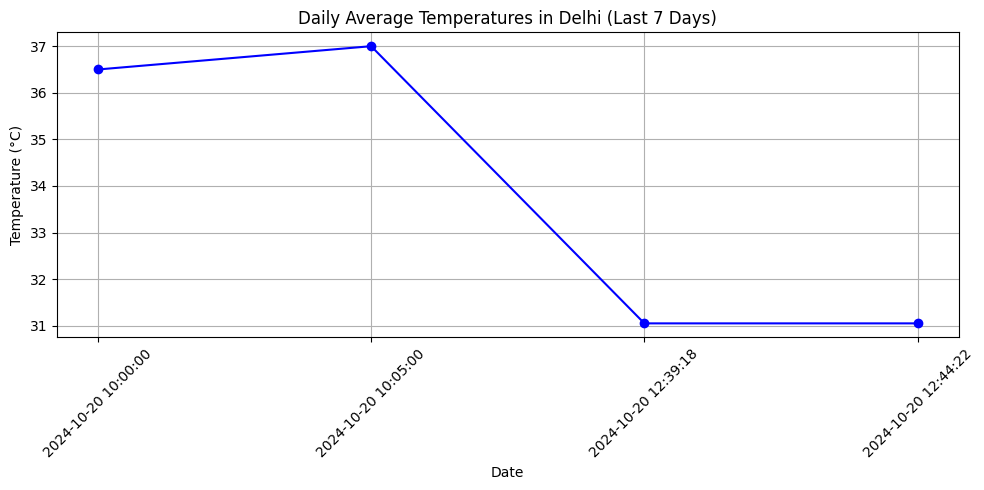

In [24]:
# Visualize daily temperatures for Delhi
visualize_daily_temperatures('Delhi')


In [25]:
# Update weather data extraction in get_weather_data
humidity = data['main']['humidity']  # Humidity
wind_speed = data['wind']['speed']  # Wind speed
pressure = data['main']['pressure']  # Atmospheric pressure

# Add to the weather_data dictionary
weather_data['humidity'] = humidity
weather_data['wind_speed'] = wind_speed
weather_data['pressure'] = pressure


NameError: name 'data' is not defined

In [26]:
def get_weather_data(city):
    url = f'http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()  # This is where 'data' is defined

    # Extract relevant weather data
    weather_data = {
        'city': city,
        'main': data['weather'][0]['main'],  # Main weather condition
        'temp_k': data['main']['temp'],  # Temperature in Kelvin
        'feels_like_k': data['main']['feels_like'],  # Feels like temperature in Kelvin
        'dt': datetime.fromtimestamp(data['dt'], tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S'),  # Convert timestamp to readable format
        'humidity': data['main']['humidity'],  # Humidity
        'wind_speed': data['wind']['speed'],  # Wind speed
        'pressure': data['main']['pressure']  # Atmospheric pressure
    }

    # Convert temperature from Kelvin to Celsius
    temp_c = kelvin_to_celsius(weather_data['temp_k'])

    # Store the data in the SQLite database
    store_weather_data(city, weather_data['dt'], temp_c, weather_data['humidity'], weather_data['wind_speed'], weather_data['pressure'], weather_data['main'])

    # Check for alerts
    check_weather_alert(city, temp_c)

    return weather_data


In [27]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS weather (
    city TEXT,
    dt TEXT,
    temp_c REAL,
    humidity REAL,
    wind_speed REAL,
    pressure REAL,
    main TEXT
)
''')


In [28]:
def get_weather_forecast(city):
    url = f'http://api.openweathermap.org/data/2.5/onecall?lat={lat}&lon={lon}&exclude=current,minutely,hourly&appid={API_KEY}'
    response = requests.get(url)
    data = response.json()
    # Process the forecast data


In [29]:
import smtplib
from email.mime.text import MIMEText

def send_alert_email(city, temp):
    msg = MIMEText(f"ALERT: {city} has exceeded the temperature threshold of {THRESHOLD['high_temp']}°C. Current temperature: {temp}°C.")
    msg['Subject'] = f'Weather Alert for {city}'
    msg['From'] = 'your_email@example.com'
    msg['To'] = 'recipient_email@example.com'

    with smtplib.SMTP('smtp.gmail.com', 587) as server:
        server.starttls()
        server.login('your_email@example.com', 'your_email_password')
        server.send_message(msg)


In [30]:
def visualize_humidity(city):
    # Query and visualize humidity data
    pass
